# Traffic Sign Recognition

Importing all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers  
from keras.optimizers import adam_v2
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

Assign the dataset path to variables

In [2]:
# Paths to resource folder, training and testing.
data_dir = r'/Users/Vahinreddy/Desktop/signRecognition/archive'
train_path = r'/Users/Vahinreddy/Desktop/signRecognition/archive/Train'
test_path = r'/Users/Vahinreddy/Desktop/signRecognition/archive/Test'

# Preaet image dimensions and color channels
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
# Number of categories
import os
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

Assigning all possible signs into a dictionary

In [4]:
classes = { 0:'Speed Limit (20km/h)',
            1:'Speed Limit (30km/h)',
            2:'Speed Limit (50km/h)',
            3:'Speed Limit (60km/h)',
            4:'Speed Limit (70km/h)',
            5:'Speed Limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed Limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing vehicles over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicle',
            16:'Vehicles > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing vehicles > 3.5 tons'}

Visualizing the dataset

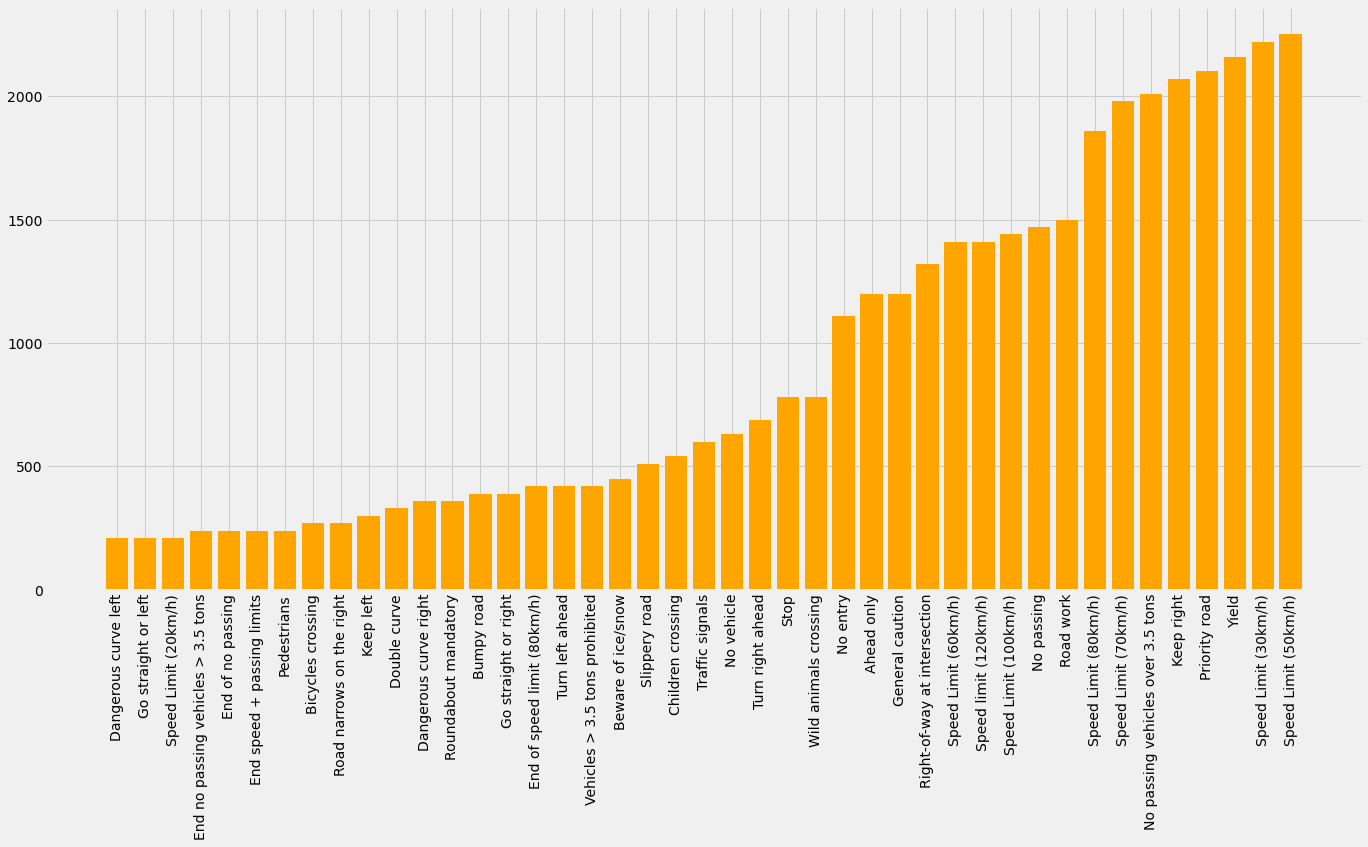

In [5]:
# Setting folders to the directory
folders = os.listdir(train_path)

# Creating empty values of train_number and class_num
train_number = []
class_num = []

# Scan every folder from folders and note down the following:
#   No. of files in total
#   No. of files with respect to "classes"
for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_list = zip(train_number,class_num)
# Sorting the zipped values in ascending order
sorted_pairs = sorted(zipped_list)
# Set the sorted pairs into a new tuple called tuples
tuples = zip(*sorted_pairs)
# Set every value in the tuples list to corresponding train_number and class_num
train_number, class_num = [ list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num,train_number,color='orange')
plt.xticks(class_num, rotation='vertical')
plt.show()

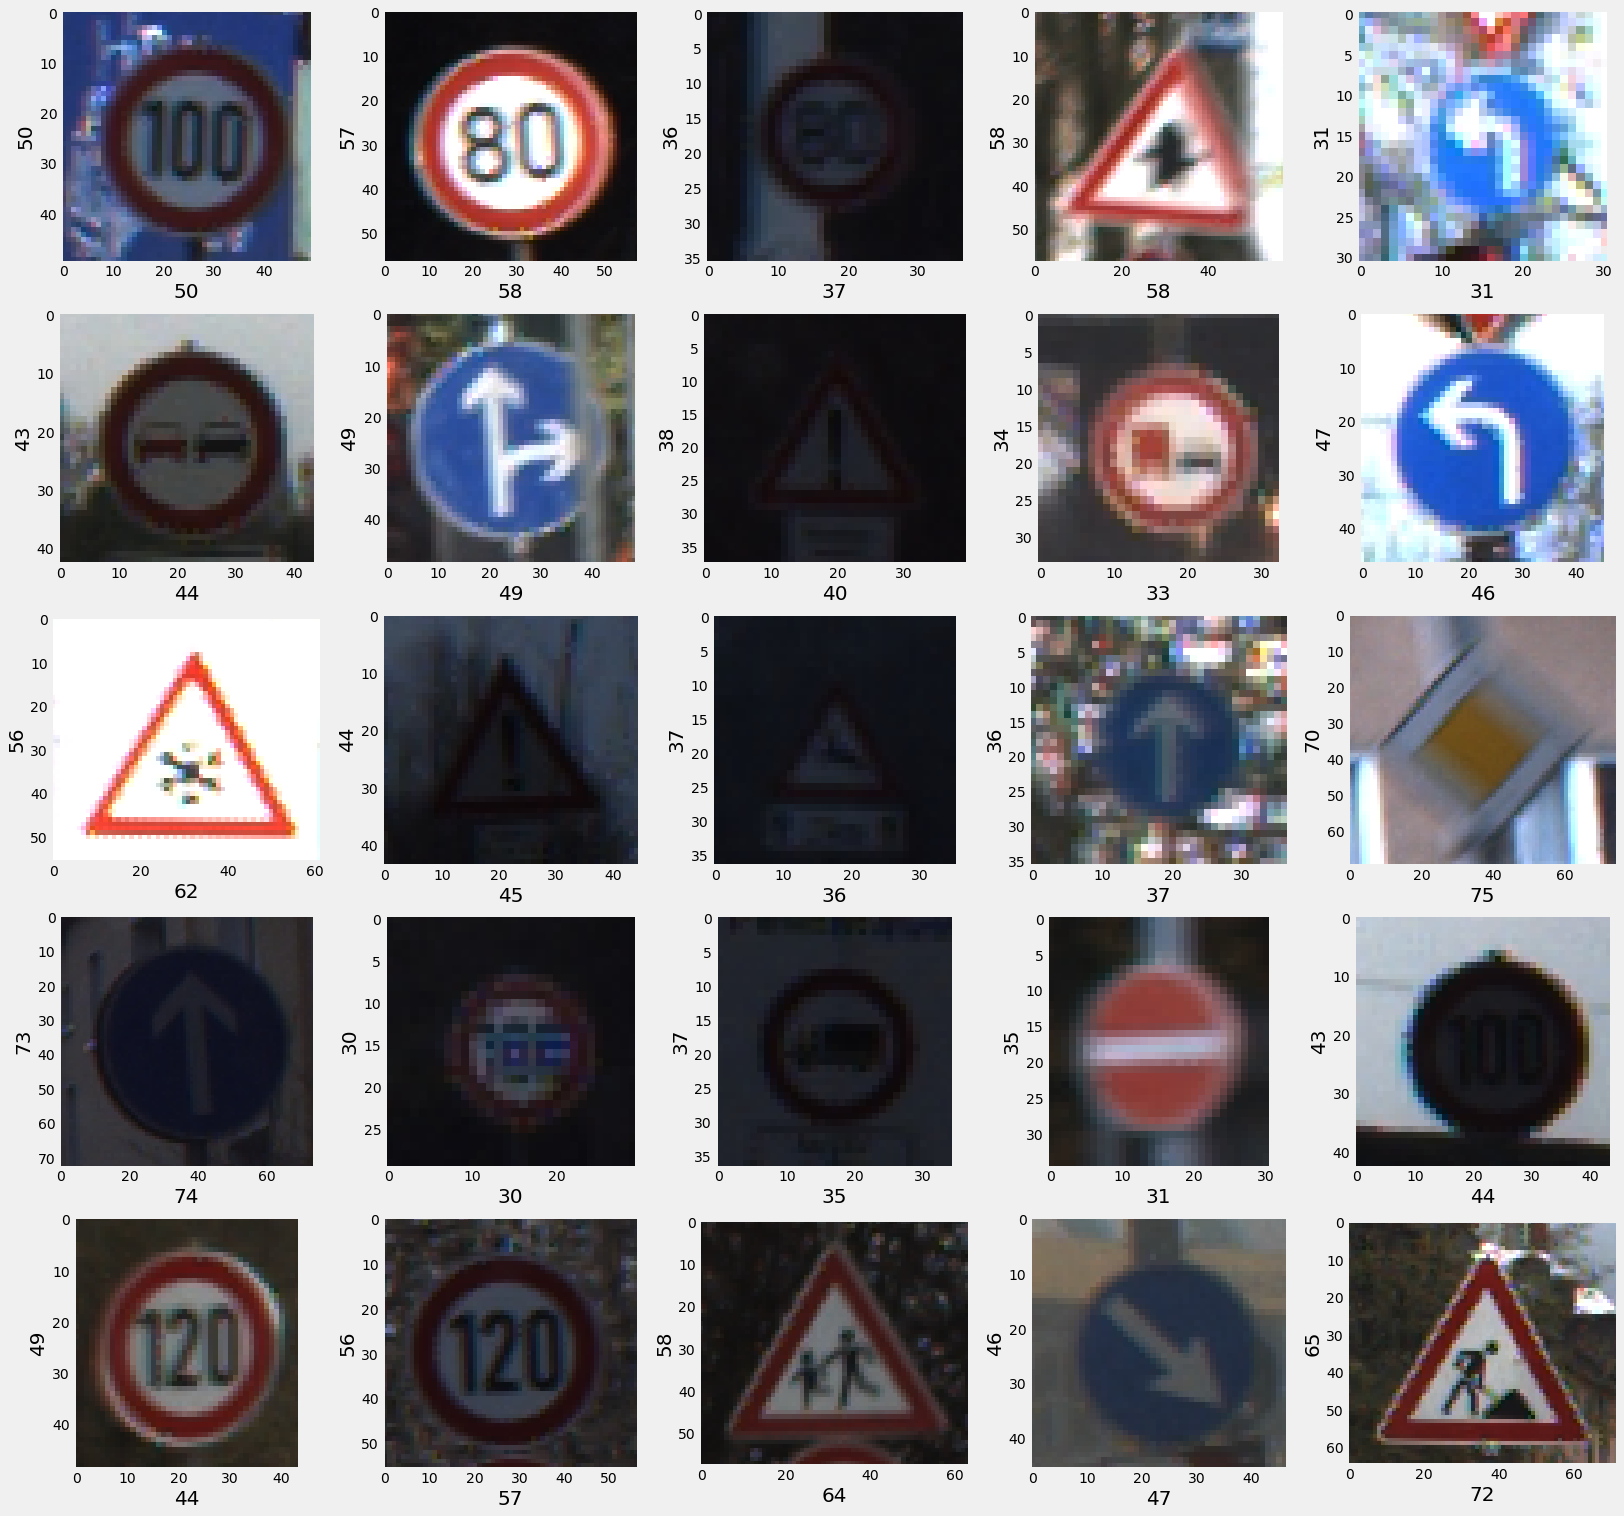

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

# Read the csv file containing the following information:
#       Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
#       And place them into variables.
test = pd.read_csv(data_dir+'/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(None)
    plt.xlabel(rand_img.shape[1],fontsize = 20)
    plt.ylabel(rand_img.shape[0],fontsize = 20)

Collecting the Training Data

In [7]:
image_data = []
image_label = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image,'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT,IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_label.append(i)
        except:
            print("Error in " + img)
    
# Changing the list to numpy array
image_data = np.array(image_data)
image_label = np.array(image_label)

print(image_data.shape, image_label.shape)

(39209, 30, 30, 3) (39209,)


Shuffling the training data

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_label = image_label[shuffle_indexes]

Splitting the data into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data,image_label,test_size=0.3,random_state=42,shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape",X_train.shape)
print("X_valid.shape",X_val.shape)
print("y_train.shape",y_train.shape)
print("y_valid.shape",y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


Encoding the labels 

In [10]:
y_train = keras.utils.to_categorical(y_train,NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val,NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


Making the model

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_HEIGHT,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [12]:
lr = 0.001
epochs = 30

opt = adam_v2.Adam(learning_rate=lr, decay = lr/(epochs*0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs = epochs, validation_data=(X_val,y_val))

Epoch 1/30
858/858 [==============================] - 37s 43ms/step - loss: 1.0419 - accuracy: 0.7169 - val_loss: 0.1387 - val_accuracy: 0.9536
Epoch 2/30
858/858 [==============================] - 37s 43ms/step - loss: 0.1709 - accuracy: 0.9475 - val_loss: 0.0989 - val_accuracy: 0.9695
Epoch 3/30
858/858 [==============================] - 37s 43ms/step - loss: 0.1120 - accuracy: 0.9666 - val_loss: 0.0224 - val_accuracy: 0.9920
Epoch 4/30
858/858 [==============================] - 37s 43ms/step - loss: 0.0771 - accuracy: 0.9766 - val_loss: 0.0122 - val_accuracy: 0.9963
Epoch 5/30
858/858 [==============================] - 36s 42ms/step - loss: 0.0663 - accuracy: 0.9804 - val_loss: 0.0081 - val_accuracy: 0.9985
Epoch 6/30
858/858 [==============================] - 36s 42ms/step - loss: 0.0575 - accuracy: 0.9815 - val_loss: 0.0113 - val_accuracy: 0.9969
Epoch 7/30
858/858 [==============================] - 36s 42ms/step - loss: 0.0472 - accuracy: 0.9856 - val_loss: 0.0069 - val_accuracy:

In [14]:
model.save("model.h5")

Evaluating Model performance

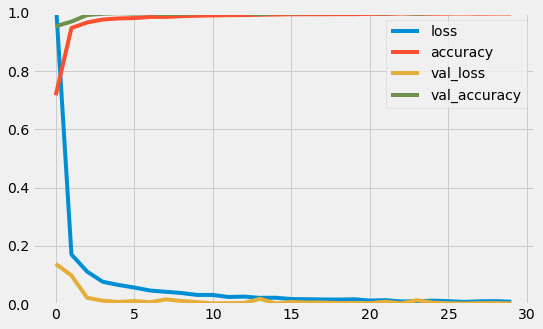

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [16]:
test = pd.read_csv(data_dir + '/Test.csv')

label = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT,IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

#pred = model.predict_classes(X_test)
pred_x = model.predict(X_test)
pred = np.argmax(pred_x,axis=1)
# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(label, pred)*100)

Test Data accuracy:  98.75692794932701


In [17]:
from sklearn.metrics import classification_report

print(classification_report(label,pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      1.00      0.99       630
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00       450
           8       1.00      0.99      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.94      0.97       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

Loading the Test data and running predictions

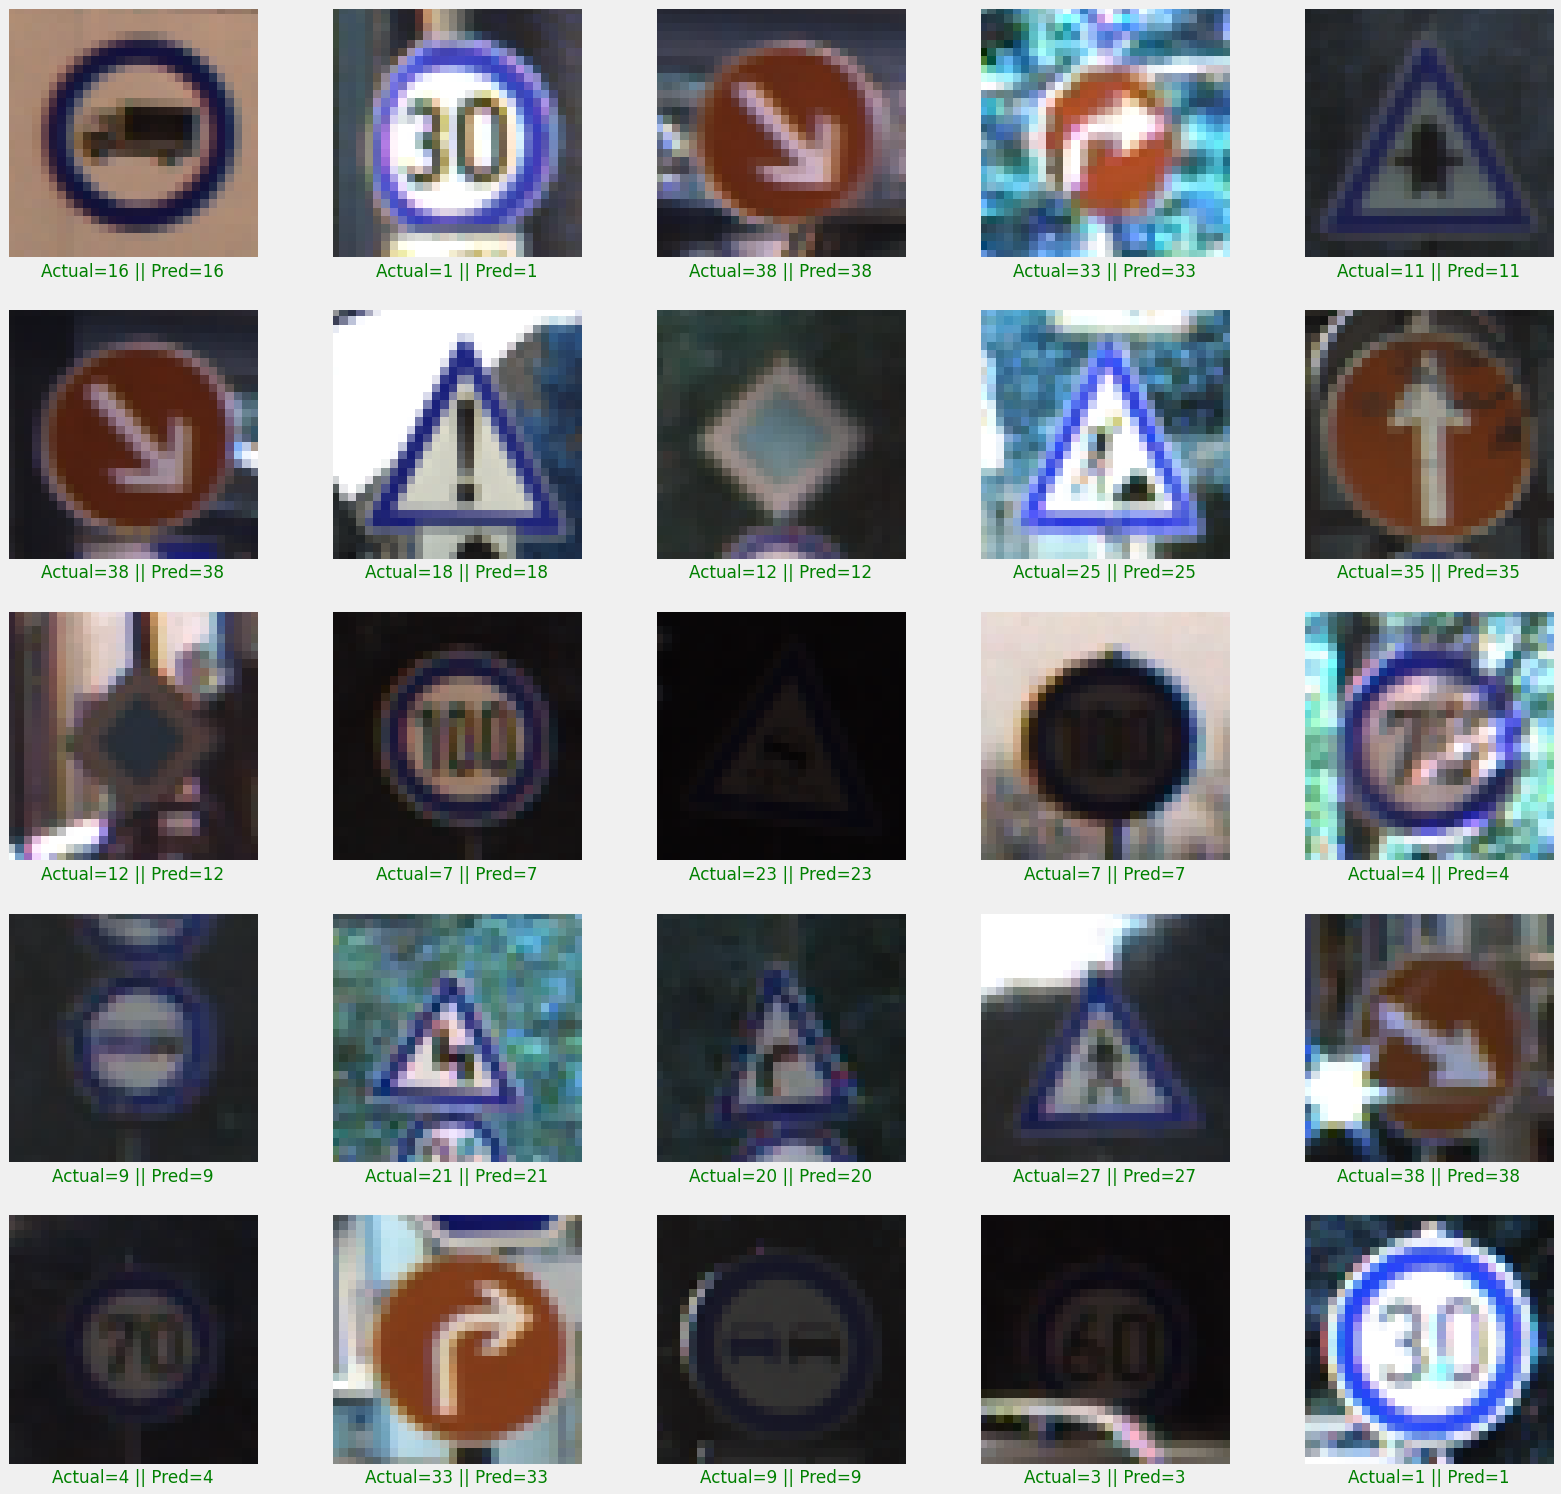

In [18]:
plt.figure(figsize=(25,25))

start_index = 0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index+i]
    actual = label[start_index +i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual,prediction),color = col)
    plt.imshow(X_test[start_index+i])
plt.show()